In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
stock_data = yf.download('AMZN', start='2018-01-01', end=None)
stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,58.599998,59.500000,58.525501,59.450500,59.450500,53890000
2018-01-03,59.415001,60.274502,59.415001,60.209999,60.209999,62176000
2018-01-04,60.250000,60.793499,60.233002,60.479500,60.479500,60442000
2018-01-05,60.875500,61.457001,60.500000,61.457001,61.457001,70894000
2018-01-08,61.799999,62.653999,61.601501,62.343498,62.343498,85590000


# data visualization

Text(0, 0.5, 'Prices ($)')

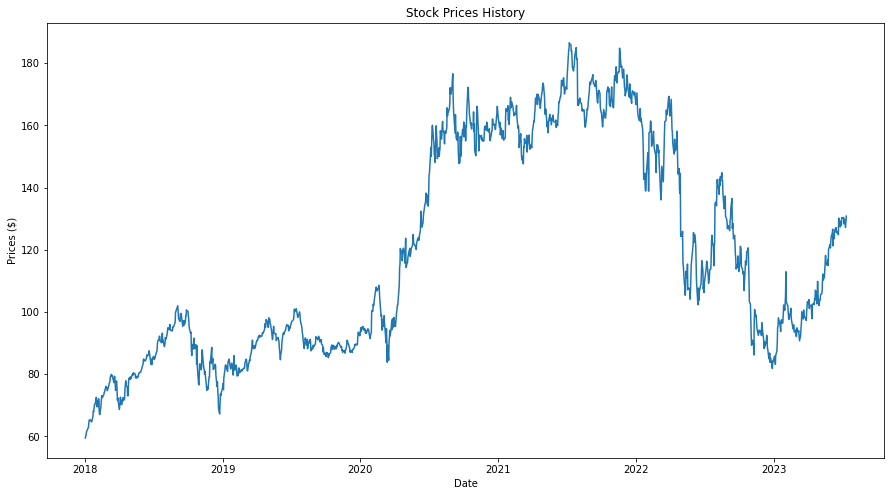

In [3]:
#lets plot the graph of amazon's sales 
plt.figure(figsize=(15, 8))
plt.plot(stock_data['Close'])
#labelling the graph 
plt.title('Stock Prices History')
plt.xlabel('Date')
plt.ylabel('Prices ($)')


In [4]:
#lets store the closing prices 
close_prices = stock_data['Close']
cpvalues = close_prices.values

training_data_len = math.ceil(len(cpvalues)* 0.8)


In [5]:
#normalizing stock data 
scaler = MinMaxScaler(feature_range=(0,1))


In [6]:
#reshape into 2d array 
scaled_data = scaler.fit_transform(cpvalues.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]



In [7]:
x_train = []
y_train = []
#prediction will be based on for next  60 days
#to measure the accuracy of our model we will predict the value of 60 days and compare with the real price
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
#convert intonummpy array format accepted by tensor flow     
x_train, y_train = np.array(x_train), np.array(y_train)
#convert into 3d array to train lstm model 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = cpvalues[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
#convert into 3d array to train lstm model
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# LSTM NETWORK ARCHITECTURE 

In [15]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1052/1052 [==============================] - 20s 16ms/step - loss: 0.0012
Epoch 2/3
1052/1052 [==============================] - 17s 17ms/step - loss: 9.2118e-04
Epoch 3/3
1052/1052 [==============================] - 17s 17ms/step - loss: 0.0011


In [21]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

9/9 [==============================] - 0s 20ms/step


0.3079970380385145

# Predicting the stock price vs the real stock price 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15256\154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


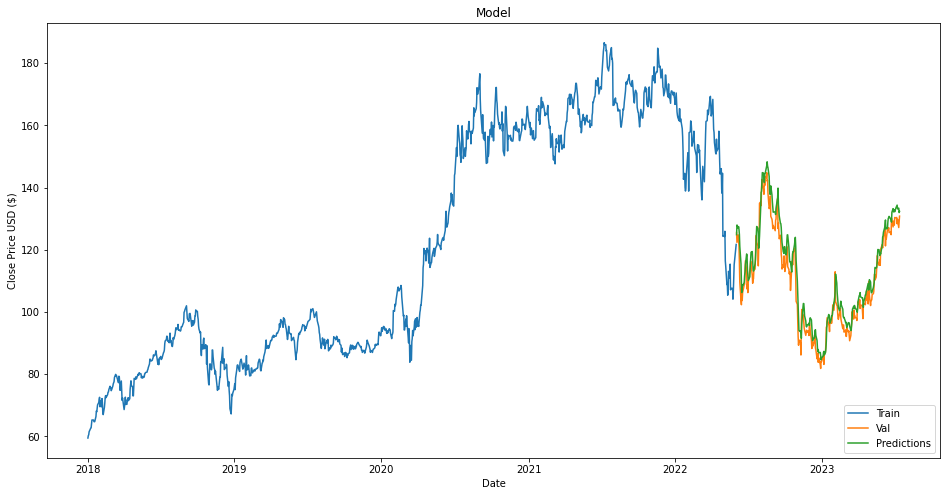

In [12]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()